In [191]:
# optional but useful for debugging - reimports modules after editing and saving .py files
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [192]:
import numpy as np
import astropy
from astropy import units as u
import astromet
import matplotlib.pyplot as plt
import matplotlib as mpl

In [193]:
dr2period=22/12 # in years
edr3Period=34/12 # in years
mas=astromet.mas # conversion from degrees to milli-arcseconds

In [194]:
# times when system is observed [years] relative to start of Gaia's observations (2456863.94 BJD)
ts=np.sort(edr3Period*(-0.5+np.random.rand(64)))

# an object wich holds all the necessary parameters to find the astrometric path
params=astromet.params()

# For this example we'll generate a random binary system

# center of mass parameters
params.RA=360*np.random.rand()
params.Dec=90*(-1+2*np.random.rand())
print('RA and Dec [degrees]: \n',params.RA,params.Dec)
params.pmRA=10*np.random.randn()
params.pmDec=10*np.random.randn()
print('Proper motion in RA and Dec [mas/yr]: \n',params.pmRA,params.pmDec)
params.pllx=10*np.random.rand()
print('Parallax [mas]: \n',params.pllx)

# binary parameters
params.M=10*np.random.rand()**2
print('Mass of brightest source [mSun]: \n',params.M)
params.a=5*np.random.rand()
print('Semi-major axis [AU]: \n',params.a)
params.e=np.random.rand()
print('Eccentricity [dimensionless]: \n',params.e)
params.q=10*(np.random.rand()**4)
params.l=np.random.rand()
print('Light (l<1) and mass (q) ratios of binary [dimensionless]: \n',params.l,params.q)
params.vPhi=2*np.pi*np.random.rand()
params.vTheta=np.pi*np.random.rand()
print('On-sky projection angles (vPhi and vTheta) of binary [radians]: \n',params.vPhi,params.vTheta)
params.vOmega=2*np.pi*np.random.rand()
print('On-sky orientation angle of binary [radians]: \n',params.vOmega)
params.tPeri=astromet.period(params)*np.random.rand()
print('Time of first binary periapse [years]: \n',params.tPeri)

RA and Dec [degrees]: 
 251.0638132409749 -25.454974096070913
Proper motion in RA and Dec [mas/yr]: 
 -20.573190246139923 -8.110165050195985
Parallax [mas]: 
 1.4807751142289693
Mass of brightest source [mSun]: 
 0.1334261739918592
Semi-major axis [AU]: 
 2.817205088257033
Eccentricity [dimensionless]: 
 0.5119660065296658
Light (l<1) and mass (q) ratios of binary [dimensionless]: 
 0.8225024901426348 2.3795483264924004
On-sky projection angles (vPhi and vTheta) of binary [radians]: 
 5.133823893558351 2.4965516398165715
On-sky orientation angle of binary [radians]: 
 5.77965566415448
Time of first binary periapse [years]: 
 2.0731433401075976


In [198]:
# on sky paths [degrees]
ras,decs=astromet.path(ts,params,t0=2)

# adding random (1/3 mas) error
astError=1/10
ras=ras+astError*mas*np.random.randn(ras.size)
decs=decs+astError*mas*np.random.randn(ras.size)

# fitting for offset from first obs (delta RA_0 & delta Dec_0), proper motion and parralax
fitParams,fitCovariance=astromet.fit(ts,ras,decs,obsError=astError,t0=2)
print('original parameters [mas]: \n',0,0,params.pmRA,params.pmDec,params.pllx)
print('derived parameters [mas]: \n',fitParams)
# extracting single parameter errors from covariance matrix
fitErrors=np.sqrt(np.diagonal(fitCovariance))/astError
print('derived parameter error [mas]: \n',fitErrors)
# note that parameters may not agree within error bars due to binary contribution

print('\ncovariance matrix [mas**2]: \n',fitCovariance)

'''
# mistake somewhere in this calibration
# ruwe is sqrt magnitude of covariance matrix normalised by error
uwe=np.sqrt(np.linalg.norm(fitCovariance))/astError
print('UWE [dimensionless]: \n',uwe)
'''

original parameters [mas]: 
 0 0 -20.573190246139923 -8.110165050195985 1.4807751142289693
derived parameters [mas]: 
 [-41.87914684 -15.63483289 -20.27771624  -7.65099371   1.45137119]
derived parameter error [mas]: 
 [0.31474266 0.3018114  0.13985146 0.13854823 0.15231813]

covariance matrix [mas**2]: 
 [[ 9.90629425e-04 -2.44975774e-06  3.63025445e-04  3.62249365e-06
  -1.36069998e-04]
 [-2.44975774e-06  9.10901198e-04  5.34049581e-07  3.80311470e-04
   4.17699511e-06]
 [ 3.63025445e-04  5.34049581e-07  1.95584306e-04 -7.89707158e-07
   2.96633925e-05]
 [ 3.62249365e-06  3.80311470e-04 -7.89707158e-07  1.91956128e-04
  -6.17658557e-06]
 [-1.36069998e-04  4.17699511e-06  2.96633925e-05 -6.17658557e-06
   2.32008131e-04]]


"\n# mistake somewhere in this calibration\n# ruwe is sqrt magnitude of covariance matrix normalised by error\nuwe=np.sqrt(np.linalg.norm(fitCovariance))/astError\nprint('UWE [dimensionless]: \n',uwe)\n"

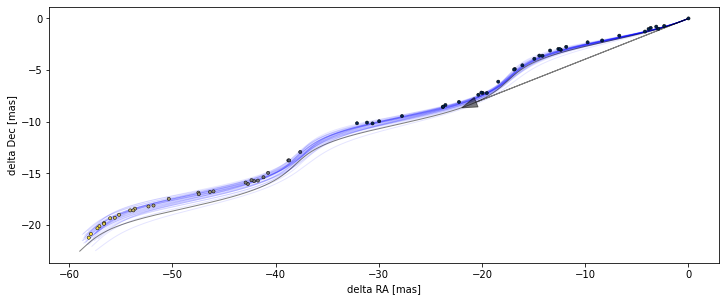

In [199]:
# plotting on sky motion
qFig=plt.figure(figsize=(12,8))
qPl=plt.gca() # defining matplotlib axis object on which to plot

deltaRas=(ras-ras[0])/mas # posn relative to first observation in mas
deltaDecs=(decs-decs[0])/mas
cs=mpl.cm.cividis(ts/ts[-1]) # optional, but I like to color by time
qPl.scatter(deltaRas,deltaDecs,s=10,c=cs,zorder=2,edgecolors='k',lw=0.5)

# optional - adding the centre of mass motion (grey) for reference
tUniform=np.linspace(ts[0],ts[-1],1000)
comRas,comDecs=astromet.comPath(tUniform,params,t0=2)
deltaComRas=(comRas-comRas[0])/mas
deltaComDecs=(comDecs-comDecs[0])/mas
qPl.plot(deltaComRas,deltaComDecs,lw=1,c='k',alpha=0.5,zorder=1)

# optional - adding fitted motion (blue)
for i in range(32):
    fitPs=astromet.params()
    fitPs.RA=np.median(ras)+mas*(fitParams[0]+fitErrors[0]*np.random.randn())
    fitPs.Dec=np.median(decs)+mas*(fitParams[1]+fitErrors[1]*np.random.randn())
    fitPs.pmRA=fitParams[2]+fitErrors[2]*np.random.randn()
    fitPs.pmDec=fitParams[3]+fitErrors[3]*np.random.randn()
    fitPs.pllx=fitParams[4]+fitErrors[4]*np.random.randn()
    bestRas,bestDecs=astromet.comPath(tUniform,fitPs,t0=2)
    deltaBestRas=(bestRas-bestRas[0])/mas
    deltaBestDecs=(bestDecs-bestDecs[0])/mas
    qPl.plot(deltaBestRas,deltaBestDecs,lw=1,c='b',alpha=0.1,zorder=0)

# adding initial position and proper motion as arrow
qPl.arrow(0,0,params.pmRA,params.pmDec,head_width=1,color='k',alpha=0.5)

qPl.set_xlabel('delta RA [mas]')
qPl.set_ylabel('delta Dec [mas]')
qPl.set_aspect('equal')

plt.show()